# Logistic Regression via gradient descent

__Goals:__
1. Logistic regression with gradient descent, stochastic gradient descent
2. $L_2$ regularization

__Resources:__
Andrew Ng ML notes. See my personal notes as well.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import time

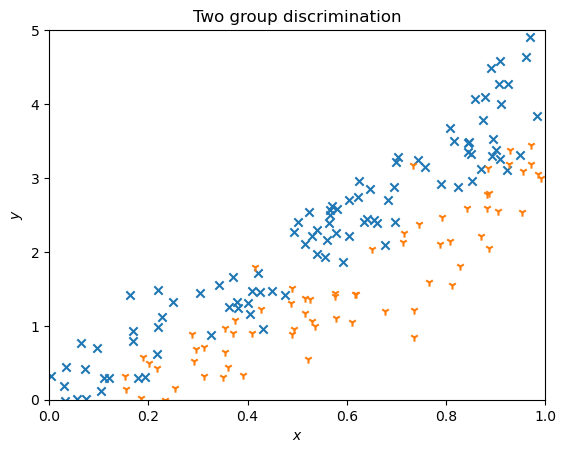

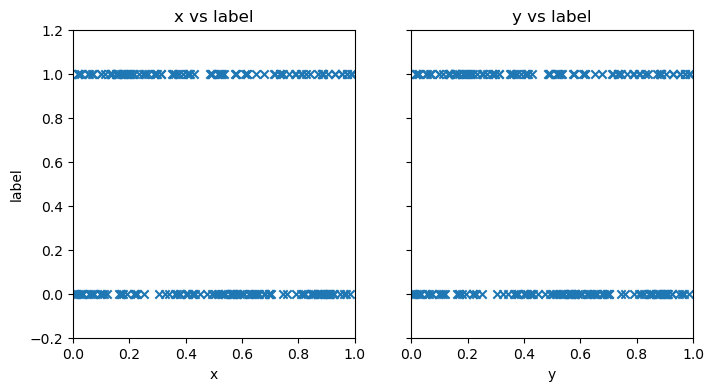

In [67]:
n_vars=100
error_var=0.4
error_weight=1

x1 = np.random.rand(n_vars,1)
y1 = 4*x1 + error_weight*np.random.normal(0,error_var,(n_vars,1))

x2 = np.random.rand(n_vars,1)
y2 = -1 + 4*x2 + error_weight*np.random.normal(0,error_var,(n_vars,1))

labels=[0,1]

labels1=np.zeros(n_vars, dtype="int32")
labels2=np.zeros(n_vars, dtype="int32")+1

labeled_data1=np.column_stack((x1,y1,labels1))
labeled_data2=np.column_stack((x2,y2,labels2))

x_full=np.vstack((x1,x2)).reshape(-1)
y_full=np.vstack((y1,y2)).reshape(-1)
labels_full=np.vstack((labels1,labels2)).reshape(-1)

df=pd.DataFrame(data={"x" : x_full, "y" : y_full , 
                      "label" : labels_full})

for i in labels:
    plt.scatter(df[df["label"]==i]["x"], df[df["label"]==i]["y"] , marker=["x","1"][i])
plt.axis([0,1.0,0, 5.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Two group discrimination')
plt.show()

fig,ax=plt.subplots(1,2, sharey=True, figsize=(8,4))
for i in labels:
    ax[i].scatter(df.iloc[:,0], df["label"], marker="x")
    ax[i].set_xlabel(["x","y"][i])
    ax[i].axis([0,1.0,-0.2, 1.2])
    ax[i].set_title(["x","y"][i] + " vs label")
ax[0].set_ylabel("label")
plt.show()

# Standard logistic regression with gradient descents

We want to do logistic regression with GD and Stochastic GD to perform Maximum Likelihood (or minimize cross-entropy loss). $y$ is now the Boolean variable, $x,y \to x_1,x_2$ are featues. Define $x_0=1$ for ease of dealing with intercept $\theta_0$. Define the cost as the average of individual log-likelihoods. (Memories a bit foggy here as to whether this description is correct)
1. GD: initlize at zero weights. Use full gradient to update $$\theta_j \to \theta_j + \alpha \, \frac{1}{n} \sum_i (y^{(i)}-h_\theta(x^{(i)})x_j^{(i)}$$
2. Stochastic GD: initlize at zero weights.  Pick random index to update $$\theta_j \to \theta_j + \alpha (y^{(i)}-h_\theta(x^{(i)})x_j^{(i)}$$
3. Batch (mini-batch) stochastic GD: initlize at zero weights. Pick random batch of indicies and update via $$\theta_j \to \theta_j + \alpha \frac{1}{n_\text{batch}} \sum_{ i \in \text{batch}} (y^{(i)}-h_\theta(x^{(i)})x_j^{(i)}$$
<!-- 1. GD: initlize at zero weights. Use full gradient to update $\theta_j \to \theta_j + \alpha \, \sum_i (y^{(i)}-h_\theta(x^{(i)})x_j^{(i)}$
2. Stochastic GD: initlize at zero weights.  Pick random index to update $\theta_j \to \theta_j + \alpha (y^{(i)}-h_\theta(x^{(i)})x_j^{(i)}$
3. Batch stochastic GD: initlize at zero weights. Pick random batch of indicies and update via $\theta_j \to \theta_j + \alpha \sum_{ i \in \text{batch}} (y^{(i)}-h_\theta(x^{(i)})x_j^{(i)}$ -->

<!-- $$ y=h_\theta(x)=\frac{1}{1+\exp(-\theta \cdot x-b)} $$
$$ x=(1,x_1,x_2) \to y=\frac{1}{1+\exp(-\theta \cdot x)}$$
$$ L(\theta,x^{(i)})$$
$$ -\nabla_\theta L(\theta,x^{(i)})$$ -->

In [69]:
num_inputs=len(df)
num_features=2

x_0_col=np.ones(num_inputs)

data=pd.DataFrame(data={"x0":x_0_col, "x1" : x_full, "x2" : y_full , 
                      "label" : labels_full})

In [38]:
def s(x):
    return 1/(1+np.exp(-x))
s=np.vectorize(s)

def grad_descent_step(weights,alpha,data):
#     grad_sum=0
#     for i in range(num_inputs):
#         x0,x1,x2,y=data.iloc[i]
#         x=np.array([x0,x1,x2])
#         w_dot_x=np.dot(weights, x)
#         grad_sum+=(y-s(w_dot_x))*x
    y=data.iloc[:,-1]
    x=data.iloc[:,:-1]
    w_dot_x=np.dot(x,weights)
    grad_sum=np.dot((y-s(w_dot_x)),x)

    weights=weights+alpha*grad_sum#/len(data)
    return np.array(weights)

def sto_grad_descent_step(weights,alpha,data):
    index=np.random.randint(len(data))
    
    y=data.iloc[index,-1]
    x=data.iloc[index,:-1]
    w_dot_x=np.dot(x, weights)
    
    weights=weights+alpha*(y-s(w_dot_x))*x
    
    return np.array(weights)

def batch_sto_grad_descent_step(weights,alpha,data,batch):
    #indices=np.random.randint(len(data), size=batch, dtype="int32") ## random samples for batch
    indices=np.random.choice(range(len(data)), size=batch, replace=False) ## random samples for batch without replacement
    y=data.iloc[indices,-1] 
    x=data.iloc[indices,:-1]
    w_dot_x=np.dot(x,weights)
    
    grad_sum=np.dot((y-s(w_dot_x)),x)

    weights=weights+alpha*grad_sum#/batch
    return np.array(weights)

In [39]:
weights=np.zeros(num_features+1)
n_iter=10**4
alpha=.4

batch=2**6

t0=time.time()
result0=weights
for i in range(n_iter):
    result0=grad_descent_step(result0,alpha,data)
t1=time.time()
print( "full batch time = ", t1-t0, f"results = {result0}")

t0=time.time()
result1=weights
for i in range(n_iter):
    result1=sto_grad_descent_step(result1,alpha,data)
t1=time.time()
print( "stochastic time = ", t1-t0, f"results = {result1}")

t0=time.time()
result2=weights
for i in range(n_iter):
    result2=batch_sto_grad_descent_step(result2,alpha,data,batch)
t1=time.time()
print( "stochastic batch time = ", t1-t0, f"results = {result2}")

full batch time =  2.17202091217041 results = [-50.27864024 428.07446093 -93.76132424]
stochastic time =  1.1859030723571777 results = [-3.58377466 26.72682269 -5.44630161]
stochastic batch time =  2.2374320030212402 results = [-18.1998576  128.49183385 -35.40944679]


In [40]:
batch=100

t0=time.time()
result2=weights
for i in range(n_iter):
    result2=batch_sto_grad_descent_step(result2,alpha,data,batch)
t1=time.time()
print( "stochastic batch time = ", t1-t0, f"results = {result2}")

stochastic batch time =  2.4235870838165283 results = [-26.8065917  191.30707126 -50.25743627]


In [41]:
# Sklearn logistic result

X=data.iloc[:,1:3]
y=data.iloc[:,-1]
clf = LogisticRegression(random_state=0).fit(X, y)

w0=clf.intercept_[0]
w1,w2=clf.coef_[0]
print([w0,w1,w2])

[0.013422058094362872, 5.166246116022802, -1.7039731217231435]


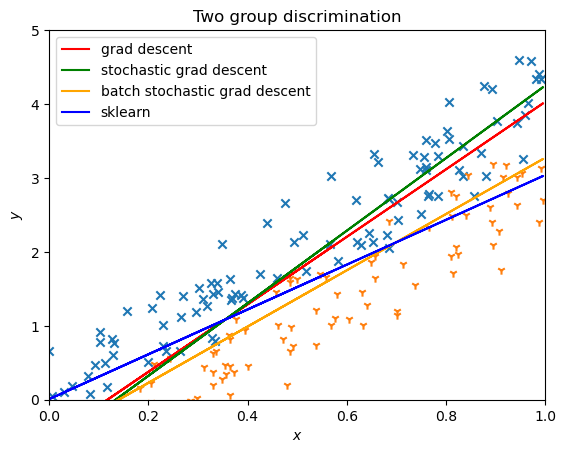

In [42]:
for i in labels:
    plt.scatter(data[data["label"]==i]["x1"], data[data["label"]==i]["x2"] , marker=["x","1"][i])
    
t0,t1,t2=result0
xrange=data['x1']
yrange=-1/t2*(t0+t1*xrange)
plt.plot(xrange,yrange, color="red", label="grad descent")

t0,t1,t2=result1
xrange=data['x1']
yrange=-1/t2*(t0+t1*xrange)
plt.plot(xrange,yrange, color="green", label="stochastic grad descent")

t0,t1,t2=result2
xrange=data['x1']
yrange=-1/t2*(t0+t1*xrange)
plt.plot(xrange,yrange, color="orange", label="batch stochastic grad descent")

xrange=X.iloc[:,0]
yrange=-1/w2*(w0+w1*xrange)
plt.plot(xrange,yrange, color="blue", label="sklearn")

plt.axis([0,1.0,0, 5.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Two group discrimination')
plt.legend()
plt.show()

## Evaluation of models

bootsrap and cross-validation

# $L_2$ regularized logistic regression

In [78]:
def grad_descent_step(weights,alpha,l2,data):
    y=data.iloc[:,-1]
    x=data.iloc[:,:-1]
    w_dot_x=w_dot_x=np.dot(x,weights)
    grad_sum=np.dot((y-s(w_dot_x)),x)

    weights=(1-l2*alpha)*weights+alpha*grad_sum/len(data)
    return np.array(weights)

def sto_grad_descent_step(weights,alpha,l2,data):
    index=np.random.randint(len(data))
    
    y=data.iloc[index,-1]
    x=data.iloc[index,:-1]
    w_dot_x=np.dot(x, weights)
    
    weights=(1-l2*alpha)*weights+alpha*(y-s(w_dot_x))*x
    
    return np.array(weights)

def batch_sto_grad_descent_step(weights,alpha,l2,data,batch):
    indices=np.random.randint(len(data), size=batch, dtype="int32") ## random samples for batch
    y=data.iloc[indices,-1] 
    x=data.iloc[indices,:-1]
    w_dot_x=np.dot(x,weights)
    
    grad_sum=np.dot((y-s(w_dot_x)),x)

    weights=(1-l2*alpha)*weights+alpha*grad_sum/batch
    return np.array(weights)

In [90]:
weights=np.zeros(num_features+1)
n_iter=10**4
alpha=.8
l2=0.005

batch=2**6

t0=time.time()
result0=weights
for i in range(n_iter):
    result0=grad_descent_step(result0,alpha,l2,data)
t1=time.time()
print( "full batch time = ", t1-t0, f"results = {result0}")

t0=time.time()
result1=weights
for i in range(n_iter*2):
    result1=sto_grad_descent_step(result1,alpha,l2, data)
t1=time.time()
print( "stochastic time = ", t1-t0, f"results = {result1}")

t0=time.time()
result2=weights
for i in range(n_iter):
    result2=batch_sto_grad_descent_step(result2,alpha,l2,data,batch)
t1=time.time()
print( "stochastic batch time = ", t1-t0, f"results = {result2}")

full batch time =  2.0593981742858887 results = [ 0.13794195  4.779379   -1.65471526]
stochastic time =  2.385209798812866 results = [-0.09304982  5.3966824  -2.77343931]
stochastic batch time =  2.1164309978485107 results = [ 0.11551702  4.77428501 -1.78934145]


In [91]:
print([w0,w1,w2])

[0.14948458939531897, 4.764607839115754, -1.655189607295202]


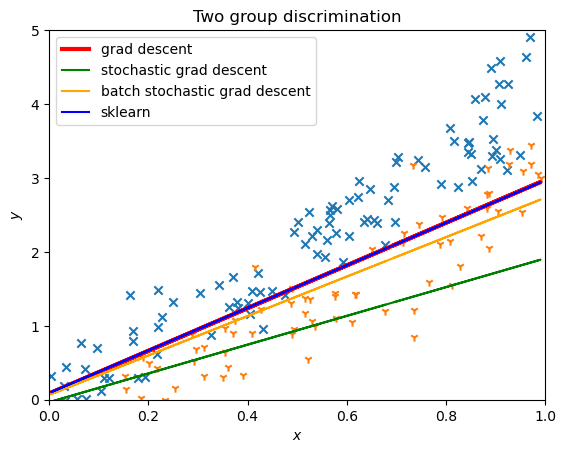

In [92]:
for i in labels:
    plt.scatter(data[data["label"]==i]["x1"], data[data["label"]==i]["x2"] , marker=["x","1"][i])
    
t0,t1,t2=result0
xrange=data['x1']
yrange=-1/t2*(t0+t1*xrange)
plt.plot(xrange,yrange, color="red", label="grad descent", linewidth=3)

t0,t1,t2=result1
xrange=data['x1']
yrange=-1/t2*(t0+t1*xrange)
plt.plot(xrange,yrange, color="green", label="stochastic grad descent")

t0,t1,t2=result2
xrange=data['x1']
yrange=-1/t2*(t0+t1*xrange)
plt.plot(xrange,yrange, color="orange", label="batch stochastic grad descent")

xrange=X.iloc[:,0]
yrange=-1/w2*(w0+w1*xrange)
plt.plot(xrange,yrange, color="blue", label="sklearn")

plt.axis([0,1.0,0, 5.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Two group discrimination')
plt.legend()
plt.show()